In [1]:
import os 
import yaml
import numpy as np 
import matplotlib.pyplot as plt 

datasets = ['dataset-room1_512_16', 'dataset-room1_512_16_8', 'dataset-room1_512_16_7', 'dataset-room1_512_16_6', 'dataset-room1_512_16_5', 'dataset-room1_512_16_4', 'dataset-room1_512_16_3']  #'dataset-room1_512_16_2'
system = 'orb_slam'
imu = ['withimu', 'withoutimu']
path_to_results = '../runs'
#path_to_results = '/home/cm2113/workspace/results'


In [2]:
def extract_results(data_folder):
    runs = sorted(os.listdir(data_folder))
    scale_error, trans_error = [], []
    for run in runs: 
        path = f'{data_folder}/{run}/saved_results/traj_est/absolute_err_statistics_sim3_-1.yaml'
        with open(path) as f:
            data = yaml.load(f, Loader=yaml.loader.FullLoader)
            scale_error.append(data["scale"]['rmse'])
            trans_error.append(data['trans']['rmse'])
    return scale_error, trans_error

In [3]:
res_s, res_t = {}, {}
std_s, std_t = {}, {}
runs = {}
for i in imu: 
    tot_s, tot_t = [], []
    s_s, s_t = [], []
    for dataset in datasets:
        data_folder = f'{path_to_results}/{dataset}/{system}/data/{i}'
        s, t = extract_results(data_folder)
        runs[dataset] = t
        tot_s.append(np.mean(s))
        tot_t.append(np.mean(t))
        s_s.append(np.std(s))
        s_t.append(np.std(t))
    res_s[i] = tot_s 
    res_t[i] = tot_t
    std_s[i] = s_s 
    std_t[i] = s_t

In [4]:
runs['dataset-room1_512_16_3']

[0.07698556738736456,
 0.07440594887841193,
 0.07413745517861743,
 0.07406735382601409,
 0.0737232537402158,
 0.07387388325613252,
 0.07348614687032536,
 0.08070559224710354,
 0.2219417977344889,
 0.07399672609642603]

In [11]:
# mean = np.mean(pi_matrix, axis = 0)
# upper_limit = mean + np.std(pi_matrix, axis = 0)
# lower_limit = mean - np.std(pi_matrix, axis = 0)
# plt.figure()
# plt.title(f'Ten iterations of experiments, line represents mean pi-value, mean =
# plt.plot(N_vec, mean, label='mean estimated pi-value')
# plt.plot(N_vec, [np.pi]*len(N_vec), label='pi')
# plt.fill_between(N_vec, upper_limit, lower_limit, alpha=0.3, label = 'sd'
# plt.legend()
# plt.show()
def plot_data(mean, std, x_vec, imu):
    upper_limit = np.array(mean) + np.array(std) 
    lower_limit = np.array(mean) - np.array(std)
    plt.title(f'Translational error, with 10 itterations for each sequence')
    plt.plot(x_vec, mean, label = f'mean - {imu}')
    plt.fill_between(x_vec, upper_limit, lower_limit, alpha=0.3, label='sd')


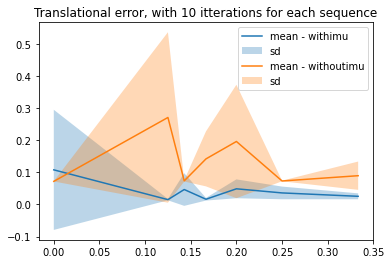

In [13]:
x = [0.0, 1.0/8.0, 1./7., 1./6., 1./5., 1./4., 1./3.]
plt.figure()
plot_data(res_t['withimu'], std_t['withimu'], x, 'withimu')
plot_data(res_t['withoutimu'], std_t['withoutimu'], x, 'withoutimu')
plt.legend()
plt.show()

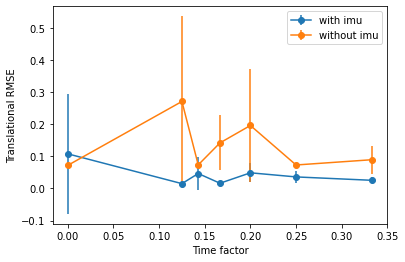

In [6]:
x = [0.0, 1.0/8.0, 1./7., 1./6., 1./5., 1./4., 1./3.] # 1./2.
plt.figure()
plt.errorbar(x, res_t['withimu'], yerr=std_t['withimu'], fmt='-o', label='with imu')
plt.errorbar(x, res_t['withoutimu'], yerr=std_t['withoutimu'], fmt='-o', label='without imu')
plt.xlabel('Time factor')
plt.ylabel('Translational RMSE')
plt.legend()
plt.show()


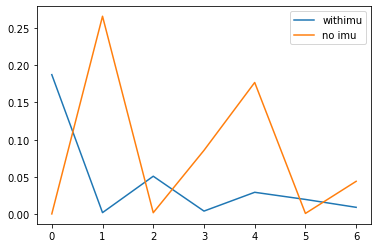

In [7]:
plt.figure()
plt.plot(std_t['withimu'], label='withimu')
plt.plot(std_t['withoutimu'], label='no imu')
plt.legend()
plt.show()
